### USD-MS AA1-501-IN2 - Diabetes Prediction Project 

- Group: 7
- Names: Hemlatha Kaur Saran, George David Asirvatharaj, Raminder Singh
- Module: Introduction to AI
- Date: 10.Aug.2025

#### Local Development Env. Setup
1.	Install python: 3.11.3
2.	Installed VSCode
3.	Add Python and jupyter extension
4.	Set kernel
5.	conda install -n base ipykernel jupyter
6.	conda -V >> conda 23.5.2
7.	pip install jupyter notebook pandas numpy matplotlib scipy scikit-learn pandoc nbconvert[webpdf] nbconvert notebook-as-pdf seaborn xgboost shap openpyxl
8.	run >> jupyter notebook
9.	Github url for code repo: https://github.com/usd-ms-aai/aai-501-in2-project-group7


In [49]:
# Import necessary libraries for EDA and Model processing
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import xgboost as xgb
import matplotlib.pyplot as plt # Importing the necessary module for plotting
import seaborn as sns

In [50]:
#1 Data Loading from dataset - the xlsx file
print("Loading Data")
data = pd.read_excel('diabetes_prediction_dataset.xlsx')
print("Dataset loaded successfully.....")

# Display basic information about the dataset
print("Dataset Info:")
data.info()
print(">>>> First 5 rows of the dataset:")
print(data.head())

Loading Data
Dataset loaded successfully.....
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
>>>> First 5 rows of the dataset:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0   

In [51]:
#2 Encode categorical variables using pd.get_dummies() (this will convert 'gender' and any other categorical columns to numeric)
data = pd.get_dummies(data, drop_first=True)

In [52]:
#3 Define the features (X) and target variable (y)
print("Separate features / target variables...")
X = data.drop('diabetes', axis=1) # Features
y = data['diabetes']              # Target variable
print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

Separate features / target variables...
Features (X) shape: (100000, 13)
Target (y) shape: (100000,)


In [53]:
#4 Normalize the data (Standardization) - this is moved to 5.1
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [54]:
#5 Split data into training and testing sets (80% train, 20% test)
# stratify=y ensures that the proportion of target classes is the same in both train and test sets,
# which is crucial for imbalanced datasets.
print("Train/test split....")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Original X shape: {X.shape}")
print(f"X_train shape before preprocessing: {X_train.shape}")
print(f"X_test shape before preprocessing: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Train/test split....
Original X shape: (100000, 13)
X_train shape before preprocessing: (80000, 13)
X_test shape before preprocessing: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)


In [55]:
#5.1 Apply preprocessing to training and testing data

# Get feature names after one-hot encoding for categorical features.
# This is important for feature importance visualization later, so we know which columns correspond to which feature.
print("Encode categorical features & Standardize features")
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

print(f"Numerical features: {list(numerical_features)}")
print(f"Categorical features: {list(categorical_features)}")

# Numerical features will be standardized
# Categorical features will be one-hot encoded
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# fit_transform on X_train to learn scaling parameters and encoding categories
X_train_processed = preprocessor.fit_transform(X_train)
# transform on X_test using parameters learned from X_train
X_test_processed = preprocessor.transform(X_test)

print(f"X_train shape after preprocessing: {X_train_processed.shape}")
print(f"X_test shape after preprocessing: {X_test_processed.shape}")

if len(categorical_features) > 0:
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = list(numerical_features) + list(ohe_feature_names)
else:
    all_feature_names = list(numerical_features)


Encode categorical features & Standardize features
Numerical features: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Categorical features: []
X_train shape after preprocessing: (80000, 6)
X_test shape after preprocessing: (20000, 6)


In [56]:
#6 Basic statistics for numerical features
print("\nBasic statistics for numerical features:")
print(data.describe())


Basic statistics for numerical features:
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.

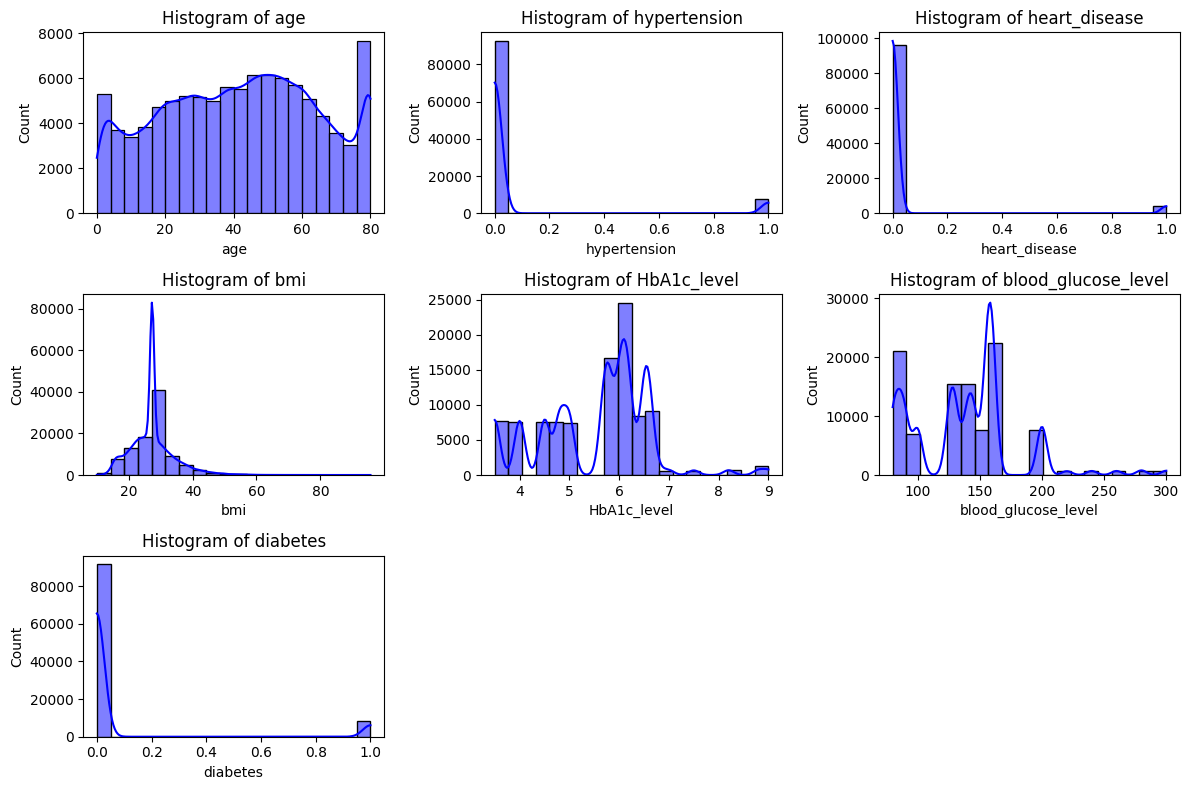

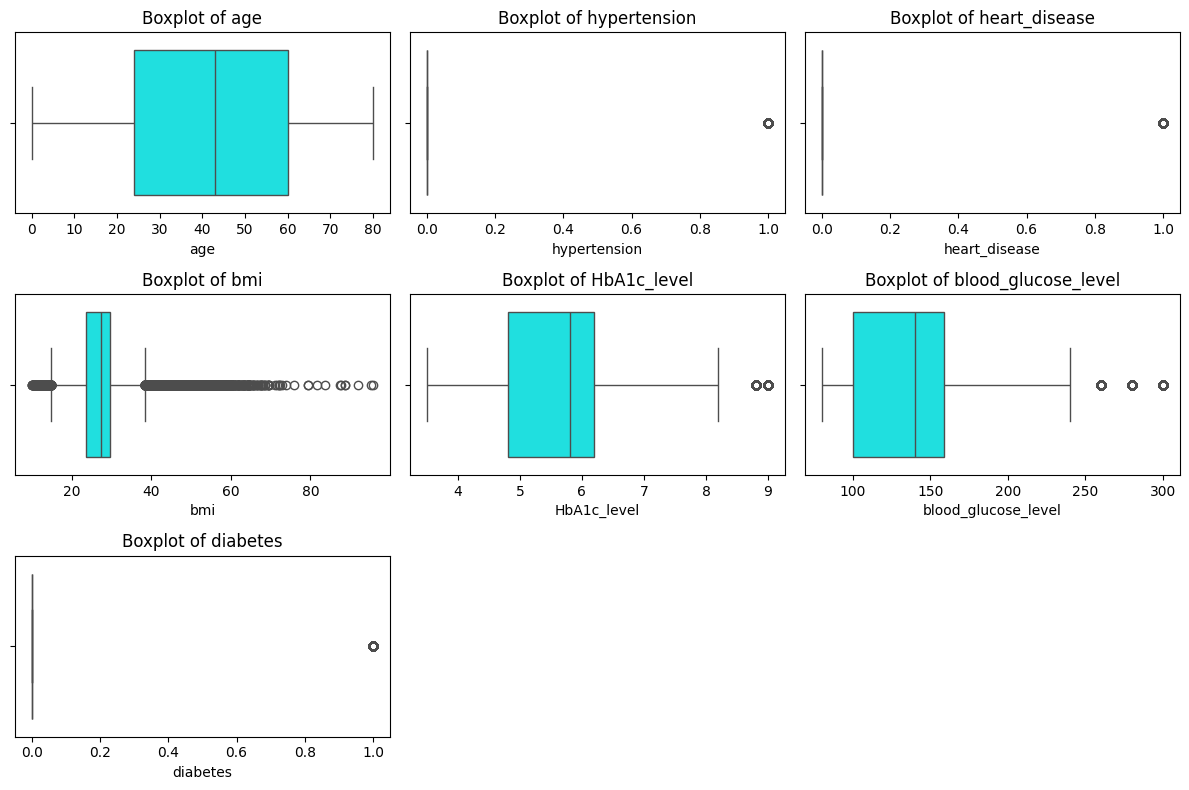

In [57]:
#7 Visualizing the distribution of numerical features (histograms)
plt.figure(figsize=(12, 8))  # Set figure size
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], kde=True, bins=20, color='blue')
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
plt.show()

# Visualizing the distribution of numerical features using boxplots
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=data[col], color='cyan')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

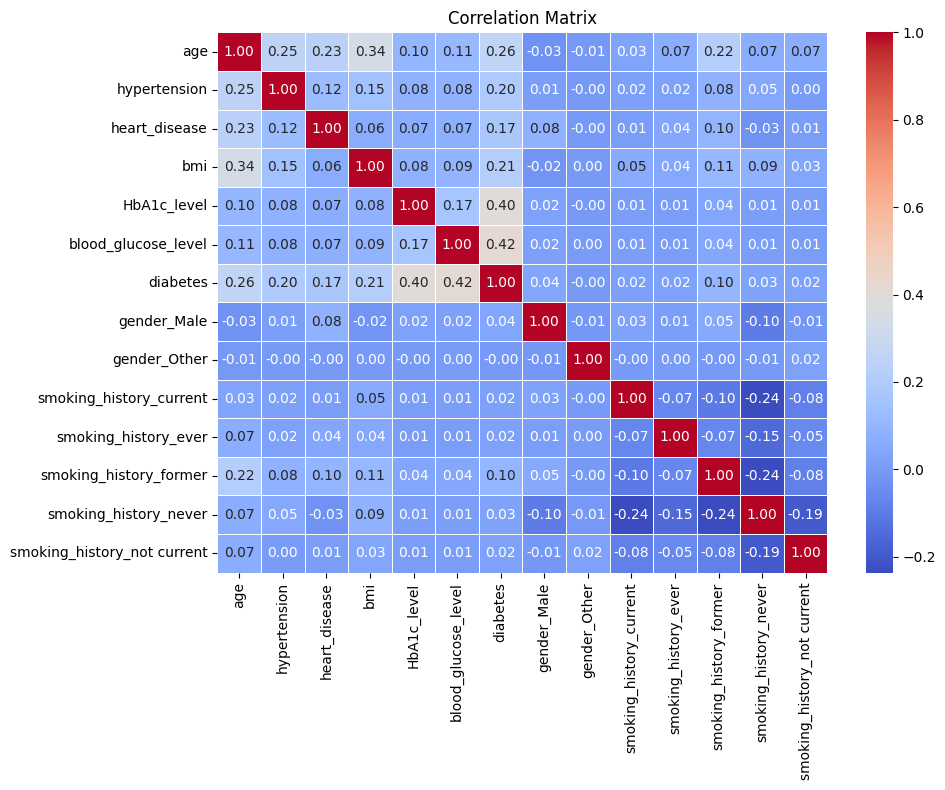

In [58]:
#8 Exploring the correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [59]:
#9. Exploring categorical variables (e.g., 'gender', 'smoking_history')
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print(f"categorical_cols: {categorical_cols}")
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, data=data, palette='Set2', hue=None)
    plt.title(f'Countplot of {col}')
    plt.tight_layout()
    plt.show()

categorical_cols: []


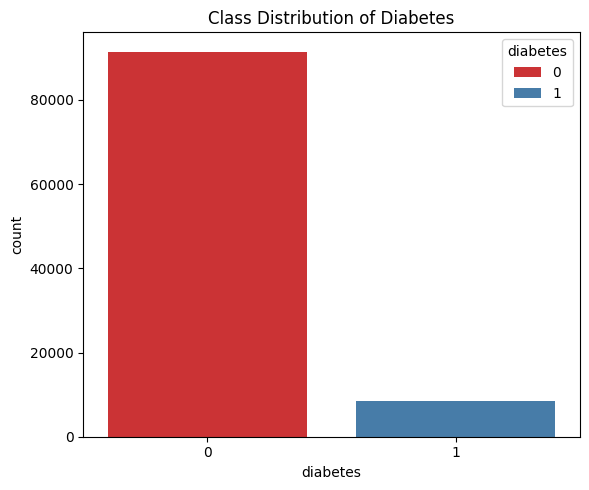

In [60]:
#10 Checking class distribution of the target variable 'diabetes'
plt.figure(figsize=(6, 5))
sns.countplot(x='diabetes', data=data, palette='Set1', hue='diabetes')
plt.title('Class Distribution of Diabetes')
plt.tight_layout()
plt.show()

In [61]:
print("Starting with 4 Models Training and Evaluation.....")
#models = {
#    "Logistic Regression": logistic_regression_model,
#    "Random Forest": random_forest_model,
#    "XGBoost": xgb_model,
#    "K-Nearest Neighbors (KNN)": knn_model
#}

Starting with 4 Models Training and Evaluation.....


In [62]:
#11 > Model1: LogisticRegression
# Initialize Logistic Regression model
# solver='liblinear' is good for small datasets and binary classification
logistic_regression_model = LogisticRegression(random_state=42, solver='liblinear') 

# Train the model
print("Training Logistic Regression Model....")
logistic_regression_model.fit(X_train_processed, y_train)

# Make predictions on the test set
print("Predicting Logistic Regression Model....")
y_pred_logreg = logistic_regression_model.predict(X_test_processed)

# Display the evaluation metrics
print(f"Evaluation > Logistic Regression Model....")
# Evaluate the model using accuracy, precision, recall, F1 score, and AUC-ROC
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg)
recall = recall_score(y_test, y_pred_logreg)
f1 = f1_score(y_test, y_pred_logreg)
roc_auc = roc_auc_score(y_test, y_pred_logreg)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Training Logistic Regression Model....
Predicting Logistic Regression Model....
Evaluation > Logistic Regression Model....
Accuracy: 0.9607
Precision: 0.8621
Recall: 0.6400
F1 Score: 0.7346
ROC AUC: 0.8152


In [63]:
#12 > Model2: Random Forest
# Initialize Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

print("Training Random Forest Classifier")
# Train the model
random_forest_model.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test_processed)

# Display the evaluation metrics
print(f"Evaluation > Random Forest Model....")
# Evaluate the model using accuracy, precision, recall, F1 score, and AUC-ROC
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_pred_rf)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Training Random Forest Classifier
Evaluation > Random Forest Model....
Accuracy: 0.9686
Precision: 0.9117
Recall: 0.6982
F1 Score: 0.7908
ROC AUC: 0.8460


In [64]:
#13 > Model3: XGBoost
print("Training XGBoost Classifier...")

# objective='binary:logistic' for binary classification
# eval_metric='logloss' is a common evaluation metric for classification
# use_label_encoder=False suppresses a future warning
#xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_processed)

# Display the evaluation metrics
print(f"Evaluation > XGBoost Classifier Model....")
# Evaluate the model using accuracy, precision, recall, F1 score, and AUC-ROC
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Training XGBoost Classifier...
Evaluation > XGBoost Classifier Model....
Accuracy: 0.9709
Precision: 0.9501
Recall: 0.6941
F1 Score: 0.8022
ROC AUC: 0.8454


In [65]:
#14 > Model4: K-Nearest Neighbors (KNN)
# Initialize K-Nearest Neighbors model
knn_model = KNeighborsClassifier()

# Train the model
knn_model.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test_processed)

# Display the evaluation metrics
print(f"Evaluation > KNN Model....")
# Evaluate the model using accuracy, precision, recall, F1 score, and AUC-ROC
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
roc_auc = roc_auc_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Evaluation > KNN Model....
Accuracy: 0.9654
Precision: 0.9078
Recall: 0.6600
F1 Score: 0.7643
ROC AUC: 0.8269


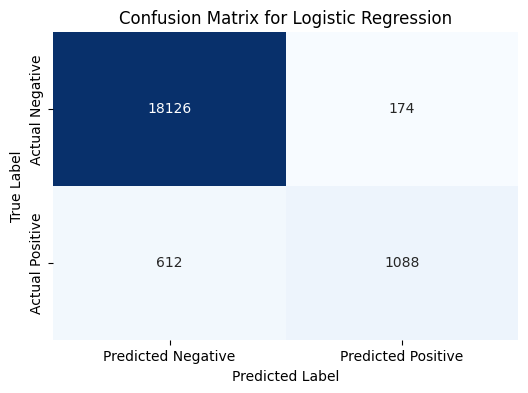

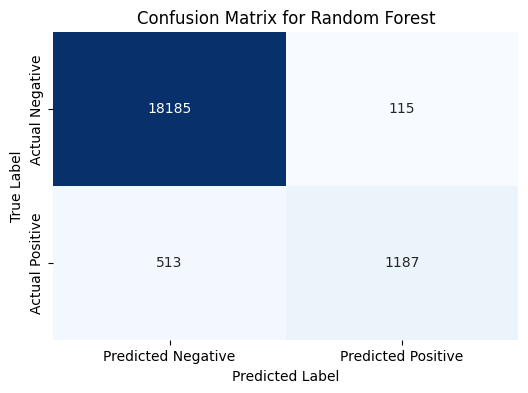

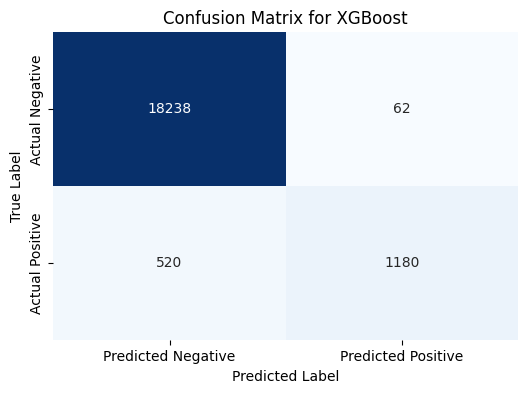

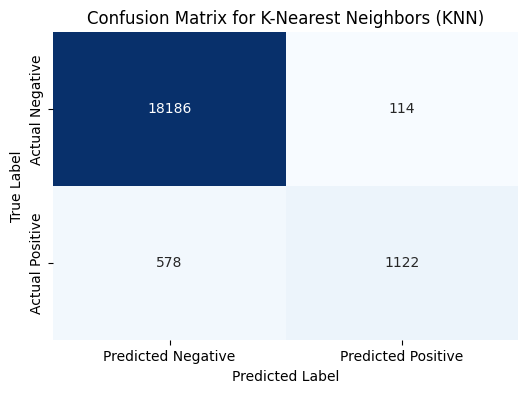

In [66]:
##15 Confusion Matrix for Models

#Model1: LogisticRegression 
name ="Logistic Regression"
confu_matrix = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(confu_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title(f'Confusion Matrix for {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Model2: Random Forest 
name ="Random Forest"
confu_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(confu_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title(f'Confusion Matrix for {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Model3: XGBoost 
name ="XGBoost"
confu_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(confu_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title(f'Confusion Matrix for {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#Model4: KNN 
name ="K-Nearest Neighbors (KNN)"
confu_matrix = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(confu_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title(f'Confusion Matrix for {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Feature Importance (Random Forest)
Top 15 Features by Importance (Random Forest):
               feature  importance
4          HbA1c_level    0.409467
5  blood_glucose_level    0.324617
3                  bmi    0.145643
0                  age    0.100718
1         hypertension    0.013193
2        heart_disease    0.006361


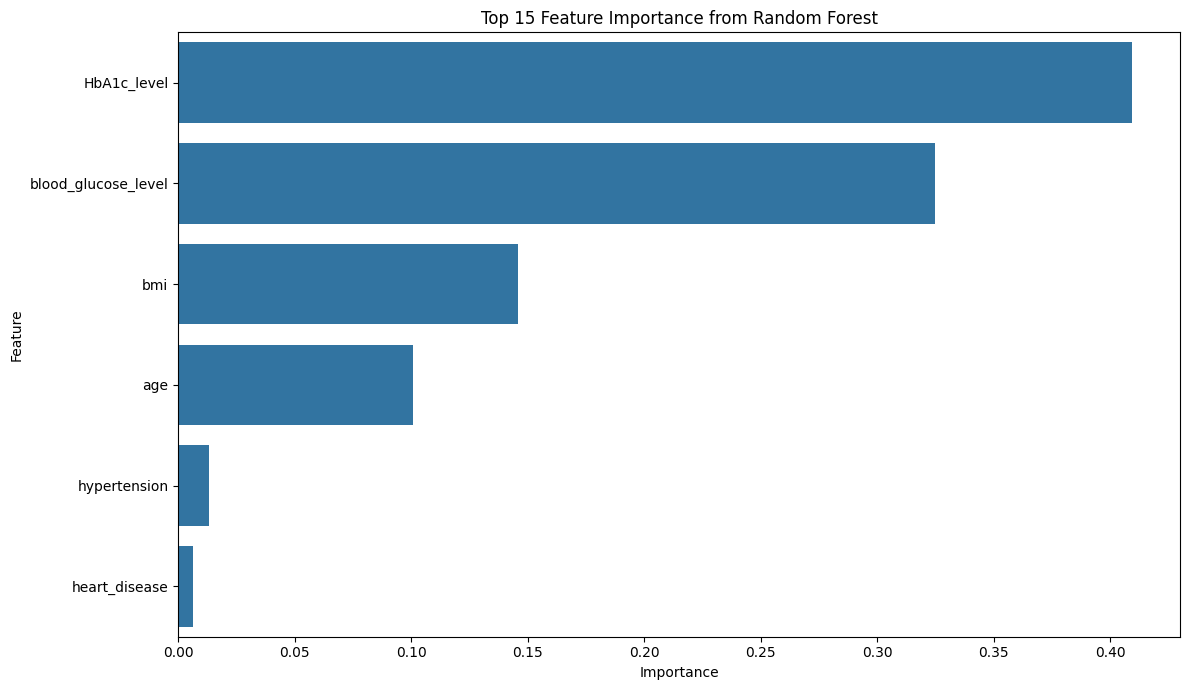

In [67]:
#16    Feature Importance (Random Forest)
print(f"Feature Importance (Random Forest)")

# Define all_feature_names for feature importance visualization
#all_feature_names = X.columns.tolist()

# Ensure the random_forest_model is trained and has feature_importances_ attribute
if hasattr(random_forest_model, 'feature_importances_'):
    importances = random_forest_model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    print("Top 15 Features by Importance (Random Forest):")
    print(feature_importance_df.head(15))

    # Visualize feature importance
    plt.figure(figsize=(12, 7))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
    plt.title('Top 15 Feature Importance from Random Forest')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Random Forest model does not have 'feature_importances_' attribute. Ensure it's trained.")

In [68]:
#17 Hyperparameter Tuning (Random Forest)
print("Hyperparameter Tuning for Random Forest")
# Define the parameter grid for GridSearchCV
# GridSearchCV is a powerful tool that automates the process of creating different new models based on the
# combinations of the hyperparameters listed below for the Random Forest model
# It measures the performance using roc_auc_score and reports the best combinations of the
# hyperparameter settings
# In short, hyperparameter tuning is how we find the optimal "settings" for our model to get the best performance.
# That is automatically done by GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300], # Number of trees in the forest [try with 100, then with 200 and then 300]
    'max_depth': [10, 20, None],     # Maximum depth of the tree (None means unlimited)
    'min_samples_split': [2, 5],     # This hyperparameter sets the minimum number of data points (or "samples") required in a node 
    # before it is allowed to split into two new nodes. 
    'min_samples_leaf': [1, 2]       # This hyperparameter sets the minimum number of data points required to be in a leaf node.
}

# Initialize GridSearchCV
# We use the preprocessed data directly here since GridSearchCV will handle the fitting.
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              cv=3, # 3-fold cross-validation
                              n_jobs=-1, # Use all available cores
                              scoring='roc_auc', # Optimize for ROC AUC
                              verbose=1)

grid_search_rf.fit(X_train_processed, y_train)
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best ROC AUC score for Random Forest (from cross-validation): {grid_search_rf.best_score_:.4f}")

# Evaluate the best Random Forest model on the test set
tuned_rf_model = grid_search_rf.best_estimator_
y_pred = tuned_rf_model.predict(X_test_processed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
print(f"Random Forest (Tuned) - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")

Hyperparameter Tuning for Random Forest
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best ROC AUC score for Random Forest (from cross-validation): 0.9749
Random Forest (Tuned) - Accuracy: 0.972, Precision: 0.993, Recall: 0.677, F1-score: 0.805


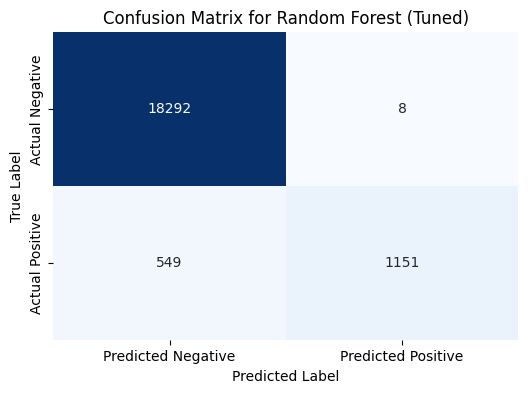

In [69]:
#17.1
# The roc_auc_score is a metric used to evaluate the performance of a classification model, especially on imbalanced datasets.
# ROC -> Receiver Operating Characteristic, AUC -> Area Under the Curve
# AUC ranges from 0 to 1
# 1 -> represents a perfect model that can perfectly distinguish between the positive and negative classes.
# 0.5 -> indicates a model that performs no better than random guessing.
# below 0.5 -> suggests the model is performing worse than random guessing and likely has a fundamental issue.

confu_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confu_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title(f'Confusion Matrix for Random Forest (Tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [70]:
#18 Hyperparameter Tuning KNN
print("Hyperparameter Tuning for KNN....")

param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=3,  n_jobs=-1, scoring='roc_auc', verbose=1)

grid_search_knn.fit(X_train_processed, y_train)
print(f"Best Hyperparameters for KNN: {grid_search_knn.best_params_}")
print(f"Best ROC AUC score for KNN (from cross-validation): {grid_search_knn.best_score_:.4f}")

# Evaluate the best Random Forest model on the test set
tuned_knn_model = grid_search_knn.best_estimator_

y_pred = tuned_knn_model.predict(X_test_processed)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
print(f" KNN (Tuned) - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")

Hyperparameter Tuning for KNN....
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Hyperparameters for KNN: {'n_neighbors': 9}
Best ROC AUC score for KNN (from cross-validation): 0.9287
 KNN (Tuned) - Accuracy: 0.966, Precision: 0.936, Recall: 0.646, F1-score: 0.764
